In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from operators import dynamical_hamiltonian, boson_ops, qubit_ops
from evolution import solve_dynamics
import pypulse

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

In [3]:
cavity_dim  = 15

g_real = jnp.pi*15.0e6  # 10 MHz
g_ref = jnp.pi*10.0e6  # 10 MHz
#g_real = jnp.pi*10.0e6  # 10 MHz

g_sim = g_real/g_ref
delta_c = 0/g_ref
delta_e = 0/g_ref
kappa = 0.1
gamma = 0.1

# Pulse Definition

In [4]:
f_0 = 0
pulse_fwhm = 5
pulse_area = jnp.pi
pulse_type = pypulse.pulses.gaussian

f_lim = pypulse.set_frequency_limits(f_0, pulse_fwhm, pulse_type, pulse_fwhm / 10)
f = jnp.linspace(-f_lim, f_lim, 5000) + f_0
frequency_pulse = pypulse.frequency_field(f, f_0, pulse_fwhm, pulse_area, pulse_type)
#frequency_pulse = pypulse.set_chirp(f, frequency_pulse, f_0, 0.1)

t_lim = pypulse.set_time_limits(f, frequency_pulse, 0.1 / pulse_fwhm)
t_data = jnp.linspace(-2*t_lim, 2*t_lim, 5000)
temporal_pulse = pypulse.time_field(f, frequency_pulse, t_data)

In [5]:
def drive(t):
    interpolated_value = jnp.interp(t, t_data + 2*t_lim, temporal_pulse)
    return interpolated_value

In [6]:
dt = 0.05
t_max = jnp.max(t_data)
t_array = jnp.arange(0, 30*t_max + dt, dt)

psi_c_vac = jnp.zeros(cavity_dim).at[0].set(1.0)
psi_q_gnd = jnp.array([1.0, 0.0])

psi_0 = jnp.kron(psi_c_vac, psi_q_gnd)
rho_initial = jnp.outer(psi_0, jnp.conj(psi_0))

H_t_func = dynamical_hamiltonian(cavity_dim, delta_c, delta_e, g_sim)

a, adag, n_op = boson_ops(cavity_dim)
sigma_m, sigma_p, sigma_e = qubit_ops()

I_c = jnp.eye(cavity_dim)
I_a = jnp.eye(2)

sigma_m_full = jnp.kron(I_c, sigma_m)
sigma_p_full = jnp.kron(I_c, sigma_p)
a_full = jnp.kron(a, I_a)
adag_full = jnp.kron(adag, I_a)

L1 = jnp.sqrt(kappa)*a_full
L2 = jnp.sqrt(gamma)*sigma_m_full

L_ops = [L1, L2]

In [7]:
rho_all_t = solve_dynamics(rho_initial, t_array, H_t_func, drive, L_ops)

/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


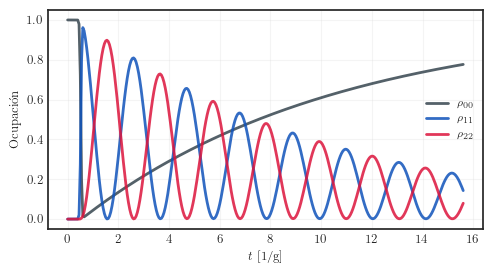

In [8]:
fig, ax = plt.subplots(figsize=(5, 2.8))
plt.plot(t_array, rho_all_t[:, 0, 0], label=r'$\rho_{00}$', linewidth = 2, color = '#36454F', alpha = 0.85)
plt.plot(t_array, rho_all_t[:, 1, 1], label=r'$\rho_{11}$', linewidth = 2, color = '#0F52BA', alpha = 0.85)
plt.plot(t_array, rho_all_t[:, 2, 2], label=r'$\rho_{22}$', linewidth = 2, color = '#DC143C', alpha = 0.85)
plt.xlabel(r'$t$ [1/g]')
plt.ylabel('Ocupación')
plt.legend()
plt.grid(alpha = 0.2)
plt.tight_layout()
plt.savefig('light_population.png', dpi = 300, bbox_inches ='tight')
plt.show()

# G1 Correlation Function

In [9]:
from correlations import g1_matrix

In [10]:
tau_array_pos =  jnp.arange(0, 60 + dt, dt)
tau_array_neg = jnp.flip(-tau_array_pos)[1:]
tau_array_full = jnp.concatenate([tau_array_neg, tau_array_pos])

G1_light_matrix = g1_matrix(
    rho_t_array = rho_all_t,
    t_array = t_array,
    a_L = a_full,
    adag_L = adag_full, 
    tau_array_pos = tau_array_pos,
    tau_array_neg = None,
    L_ops = L_ops,
    H_t_func = H_t_func,
    E_func = drive
)

G1_atom_matrix = g1_matrix(
    rho_t_array = rho_all_t,
    t_array = t_array,
    a_L = sigma_m_full,
    adag_L = sigma_p_full,
    tau_array_pos = tau_array_pos,
    tau_array_neg = None,
    L_ops = L_ops,
    H_t_func = H_t_func,
    E_func = drive
)

Calculating G1(t, tau >= 0)...


/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


Calculating G1(t, tau >= 0)...


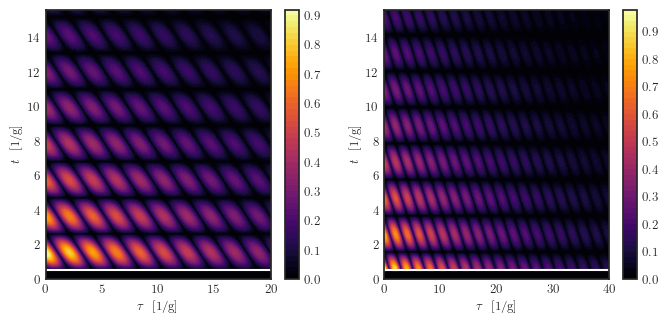

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

plot_1 = ax[0].contourf(tau_array_pos, t_array, jnp.abs(G1_light_matrix), levels = 50, cmap = 'inferno')
ax[0].set_xlabel(r'$\tau \ $ [1/g]')
ax[0].set_ylabel(r'$t \ $ [1/g]')   
ax[0].axhline(2*t_lim, color = 'w')
ax[0].set_xlim(0, 20)
cbar_light = fig.colorbar(plot_1, ax=ax[0])

plot_2 = ax[1].contourf(tau_array_pos, t_array, jnp.abs(G1_atom_matrix), levels = 50, cmap = 'inferno')
ax[1].set_xlabel(r'$\tau \ $ [1/g]')
ax[1].set_ylabel(r'$t \ $ [1/g]')
ax[1].axhline(2*t_lim, color = 'w')
ax[1].set_xlim(0, 40)
cbar_atom = fig.colorbar(plot_2, ax=ax[1])

In [12]:
g1_integrated_light = jnp.trapezoid(G1_light_matrix, x=t_array, axis=0)
g1_integrated_atom = jnp.trapezoid(G1_atom_matrix, x=t_array, axis=0)

# Emission Spectrum

In [12]:
from spectrum import calculate_spectrum_matrix

In [13]:
omega_array = jnp.arange(-4, 4, dt)

spectrum_light_matrix = calculate_spectrum_matrix(G1_light_matrix, tau_array_pos, omega_array)
spectrum_atom_matrix = calculate_spectrum_matrix(G1_atom_matrix, tau_array_pos, omega_array)

Calculating spectrum matrix S(t, w)...
Spectrum calculation complete.
Calculating spectrum matrix S(t, w)...
Spectrum calculation complete.


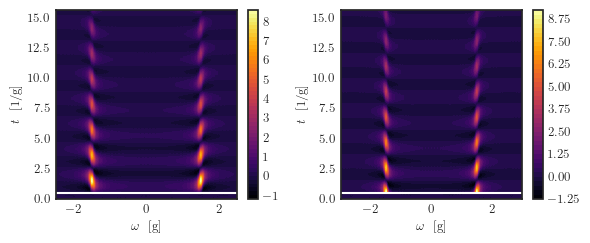

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))

plot_1 = ax[0].contourf(omega_array, t_array, spectrum_light_matrix, levels = 50, cmap = 'inferno')
ax[0].set_xlabel(r'$\omega \ $ [g]')
ax[0].set_ylabel(r'$t \ $ [1/g]')   
ax[0].axhline(2*t_lim, color = 'w')
ax[0].set_xlim(-2.5, 2.5)
cbar_light = fig.colorbar(plot_1, ax=ax[0])

plot_2 = ax[1].contourf(omega_array, t_array, spectrum_atom_matrix, levels = 50, cmap = 'inferno')
ax[1].set_xlabel(r'$\omega \ $ [g]')
ax[1].set_ylabel(r'$t \ $ [1/g]')
ax[1].set_xlim(-3.0, 3.0)
ax[1].axhline(2*t_lim, color = 'w')

cbar_atom = fig.colorbar(plot_2, ax=ax[1])

plt.tight_layout()
plt.savefig('matter_emission_spectrum.png', dpi = 300, bbox_inches ='tight')
plt.show()

In [15]:
S_integrated_light = jnp.trapezoid(spectrum_light_matrix, x=t_array, axis=0)
S_integrated_atom = jnp.trapezoid(spectrum_atom_matrix, x=t_array, axis=0)

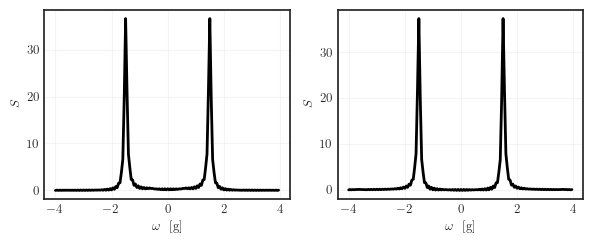

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
ax[0].plot(omega_array, S_integrated_light, linewidth = 2, color = 'k')
ax[0].set_xlabel(r'$\omega \ $ [g]')
ax[0].set_ylabel(r'$S \ $')   
ax[0].grid(alpha = 0.2)

ax[1].plot(omega_array, S_integrated_atom, linewidth = 2, color = 'k')
ax[1].set_xlabel(r'$\omega \ $ [g]')
ax[1].set_ylabel(r'$S \ $')   
ax[1].grid(alpha = 0.2)

plt.tight_layout()
plt.savefig('matter_integrated_emission_spectrum.png', dpi = 300, bbox_inches ='tight')
plt.show()